#**Deepfake Voice Detection: ASVspoof → Real-World Generalization**


## **Project Motivation**
Recent advancements in neural speech synthesis and voice cloning have made it possible to generate highly realistic fake human speech. These `deepfake` voices pose serious risks in:
- voice biometric authentication
- financial fraud & impersonation scams
- disinformation & media manipulation
- identity spoofing in telecommunications

Traditional speech processing systems are not designed to detect synthetic voices and often fail when exposed to modern voice conversion (VC) or text-to-speech (TTS) models.

## **Project Goal**

The goal of this project is to:

**Train a deep learning model on the ASVspoof 2019 dataset (Logical Access) and evaluate its performance on real-world speech data `LibriSpeech`**.  
The evaluation on Common Voice simulates a deployment scenario where the detector encounters real speech from different accents, microphones, and environments.
This allows us to study generalization — a key challenge in anti-spoofing research.

## **Dataset Overview**
ASVspoof 2019 (Logical Access) provides:  
- Real (bona fide) speech
- Spoofed (fake) speech generated using:
  - Text-to-Speech (TTS)
  - Voice Conversion (VC)  
- Protocol files describing labels & attack types.

This dataset serves as the training and validation source.  
**LibriSpeech**  provides real human speech from diverse speakers. It will be used as an out-of-domain evaluation set to measure false positives.

## **Workflow Overview.**
This project is organized into logical notebooks:  
**Notebook 1 — Data Wrangling & EDA (current)**
- unzip + inspect dataset structure
- parse ASVspoof protocol files
- create metadata table
- inspect audio durations & distributions
- listen to sample real vs spoof audio
- generate Mel-spectrograms

**Notebook 2 — Model Training**.
- build simple CNN classifier
- train on ASVspoof Logical Access
- validate on ASVspoof dev split
- save checkpoints & final weights
  
**Notebook 3 — Real-World Evaluation**.
- load Common Voice
- normalize & preprocess audio
- run inference using trained model
- analyze false positives
- discuss deployment implications

# **Data Wrangling**

## **1.0 Unzip Asvspoof archive**

In [ ]:
!unzip "//content/drive/MyDrive/Deepfake vs Real/ASVspoof/Archive.zip" -d "/content/asvspoof/"


Streaming output truncated to the last 5000 lines.
  inflating: /content/asvspoof/ASVspoof2019_LA_train/flac/LA_T_6499565.flac  
  inflating: /content/asvspoof/__MACOSX/ASVspoof2019_LA_train/flac/._LA_T_6499565.flac  
  inflating: /content/asvspoof/ASVspoof2019_LA_train/flac/LA_T_5351286.flac  
  inflating: /content/asvspoof/__MACOSX/ASVspoof2019_LA_train/flac/._LA_T_5351286.flac  
  inflating: /content/asvspoof/ASVspoof2019_LA_train/flac/LA_T_4046944.flac  
  inflating: /content/asvspoof/__MACOSX/ASVspoof2019_LA_train/flac/._LA_T_4046944.flac  
  inflating: /content/asvspoof/ASVspoof2019_LA_train/flac/LA_T_6970459.flac  
  inflating: /content/asvspoof/__MACOSX/ASVspoof2019_LA_train/flac/._LA_T_6970459.flac  
  inflating: /content/asvspoof/ASVspoof2019_LA_train/flac/LA_T_2413807.flac  
  inflating: /content/asvspoof/__MACOSX/ASVspoof2019_LA_train/flac/._LA_T_2413807.flac  
  inflating: /content/asvspoof/ASVspoof2019_LA_train/flac/LA_T_4447192.flac  
  inflating: /content/asvspoof/__MAC

In [ ]:
# Check folder structure
!ls /content/asvspoof

ASVspoof2019_LA_cm_protocols  ASVspoof2019_LA_eval   __MACOSX
ASVspoof2019_LA_dev	      ASVspoof2019_LA_train


In [ ]:
# Saving files in Drive
!cp -r /content/asvspoof/ASVspoof2019_LA_train /content/drive/MyDrive/asvspoof/
!cp -r /content/asvspoof/ASVspoof2019_LA_dev /content/drive/MyDrive/asvspoof/
!cp -r /content/asvspoof/ASVspoof2019_LA_eval /content/drive/MyDrive/asvspoof/
!cp -r /content/asvspoof/ASVspoof2019_LA_cm_protocols /content/drive/MyDrive/asvspoof/


## **1.1 Dataset Structure Overview**
After unzipping the ASVspoof Logical Access dataset, the top-level directory contains:  
- ASVspoof2019_LA_train/ — training audio (bona fide + spoof)
- ASVspoof2019_LA_dev/ — development/validation audio
- ASVspoof2019_LA_eval/ — evaluation audio (labels withheld)
- ASVspoof2019_LA_cm_protocols/ — protocol text files containing labels and metadata
- __MACOSX/ — system artifact (ignored)

The dataset is organized such that:  
- audio files reside in the train/dev/eval folders
- labels & attack types reside in the protocols folder
- train is used for fitting the model
- dev is used for validation/model selection
- eval is optional for challenge-style evaluation

## **2.0 Parsing Protocol Files**
The ASVspoof dataset stores audio and labels separately.  
The train/dev/eval folders contain the raw .flac audio, while the ASVspoof2019_LA_cm_protocols directory contains protocol text files that map each audio file to:  
- bona fide (real) or spoofed (fake) label
- spoof attack system ID (for fake samples)
- speaker IDs
- file IDs for locating audio

To train a classifier, we first convert these protocol files into a structured metadata table (Pandas DataFrame) that links each audio sample to its label and split.

## **2.1 Locate Protocol Files**

In [ ]:
import os

protocol_dir = "/content/asvspoof/ASVspoof2019_LA_cm_protocols/"
os.listdir(protocol_dir)

['ASVspoof2019.LA.cm.eval.trl.txt',
 'ASVspoof2019.LA.cm.dev.trl.txt',
 'ASVspoof2019.LA.cm.train.trn.txt']

## **2.2 Parse Training and Dev Protocols into MetaData**
The ASVspoof dataset stores labels in separate protocol text files.  
This step reads those files and converts them into a structured table (DataFrame) so we can easily work with labels during training.
Each line of the protocols contains:    
speaker_id   file_id   system_id   label.  
We extract this information and convert labels to numerical form:  
- bona-fide → 0 (real)
- spoof → 1 (fake).  
This creates our initial metadata table.

In [ ]:
import pandas as pd

def parse_protocol(path, split_name):
    rows = []

    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()

            # Example of parts:
            # ['LA_T_1000019', 'LA_T_1000019', '-', 'bonafide']

            file_id = parts[1]             # second field is always file_id
            system_id = parts[-2]          # second last field
            label_txt = parts[-1]          # last field

            # convert textual label → numeric
            label = 1 if label_txt.lower() == 'spoof' else 0

             # attack type: only valid for spoof
            attack = system_id if system_id != '-' else None

            rows.append({
                'split': split_name,
                'file_id': file_id,
                'attack': attack,
                'label': label
            })

    return pd.DataFrame(rows)



In [ ]:
# parse train and dev protocol files
train_proto = parse_protocol(protocol_dir + "ASVspoof2019.LA.cm.train.trn.txt", "train")
dev_proto   = parse_protocol(protocol_dir + "ASVspoof2019.LA.cm.dev.trl.txt", "dev")

# combine into one dataframe
metadata = pd.concat([train_proto, dev_proto], ignore_index=True)

# preview
metadata.head()

,split,file_id,attack,label
0,train,LA_T_1138215,None,0
1,train,LA_T_1271820,None,0
2,train,LA_T_1272637,None,0
3,train,LA_T_1276960,None,0
4,train,LA_T_1341447,None,0


## **3.0 Attach Audio Filepaths**
The protocol files only contain file_id values.
To load audio for training, we need to convert these into full filepaths pointing to the `.flac` audio files in the `train` and `dev` folders.  
This step adds a new column `filepath` linking each metadata row to its corresponding audio file in the dataset directory.

In [ ]:

# directories where the audio files actually live
train_audio_dir = "/content/asvspoof/ASVspoof2019_LA_train/flac/"
dev_audio_dir   = "/content/asvspoof/ASVspoof2019_LA_dev/flac/"

def add_audio_paths(df):
    filepaths = []

    # loop through each row in the metadata dataframe
    for _, row in df.iterrows():

        # the 'split' column tells us which folder to pull from (train or dev)
        if row['split'] == 'train':
            # audio files are stored as .flac → so append ".flac"
            fp = os.path.join(train_audio_dir, row['file_id'] + ".flac")
        else:
            fp = os.path.join(dev_audio_dir, row['file_id'] + ".flac")

        # store the constructed path
        filepaths.append(fp)

    # add the new column to the dataframe
    df['filepath'] = filepaths

    return df

# apply the function to our protocol metadata
metadata = add_audio_paths(metadata)

# preview first few rows
metadata.head()


,split,file_id,attack,label,filepath
0,train,LA_T_1138215,None,0,/content/asvspoof/ASVspoof2019_LA_train/flac/L...
1,train,LA_T_1271820,None,0,/content/asvspoof/ASVspoof2019_LA_train/flac/L...
2,train,LA_T_1272637,None,0,/content/asvspoof/ASVspoof2019_LA_train/flac/L...
3,train,LA_T_1276960,None,0,/content/asvspoof/ASVspoof2019_LA_train/flac/L...
4,train,LA_T_1341447,None,0,/content/asvspoof/ASVspoof2019_LA_train/flac/L...


In [ ]:
# Sanity check
missing = metadata[~metadata['filepath'].apply(os.path.exists)]
print('Missing audio files:', len(missing))

Missing audio files: 0


**At this point, we have successfully:**
- parsed the ASVspoof protocol files
- extracted labels (bona-fide vs spoof)
- converted labels into numeric form (0 = real, 1 = fake)
- combined train and dev metadata into a single DataFrame
- attached full audio filepaths for loading .flac files.  

**This structured metadata will serve as the foundation for:**
- exploratory data analysis (EDA)
- feature extraction (Mel-spectrograms)
- model training and validation

# **Exploratory Data Analysis(EDA)**
Before modeling, we perform quick EDA to make sure the dataset is correctly understood and to guide later decisions. For this project, EDA focuses on:  
- class balance (real vs spoof)
- audio duration patterns
- basic listening inspection
- spectrogram structure   
This helps us confirm data integrity and prepare for feature extraction and training.

## **4.1 Label Distroibution(Real VS Spoof)**
Before training a classifier, it's useful to inspect the balance between bona-fide (real) and spoofed (fake) samples.
This helps us understand:
-  whether the dataset is balanced
- if any class dominates
- if reweighting or sampling might be needed later

In [ ]:
# count occurrences of each label (0=real, 1=fake)
label_counts = metadata['label'].value_counts()

print("Label Distribution:")
print(label_counts)

# convert numeric labels back to human-readable form for plotting
label_map = {0: 'bona-fide (real)', 1: 'spoof'}
label_counts.index = label_counts.index.map(label_map)
label_counts


Label Distribution:
label
1    45096
0     5128
Name: count, dtype: int64


,count
label,
spoof,45096
bona-fide (real),5128


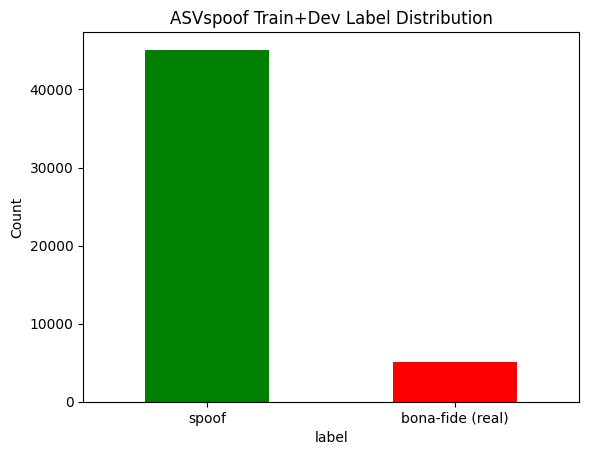

In [ ]:
# Barplot of label distribution
import matplotlib.pyplot as plt

label_counts.plot(kind='bar', color=['green', 'red'])
plt.title("ASVspoof Train+Dev Label Distribution")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()


**Label Distribution Note**.  
The ASVspoof Logical Access dataset is highly imbalanced, with many more spoofed samples than bona-fide speech. In this split:  
- Spoofed: 45,096 samples
- Real: 5,128 samples
  
This imbalance is intentional and reflects the task setting, where detecting relatively rare spoofing attempts is more important than detecting real speech. The imbalance may influence training dynamics and later evaluation metrics.

## **4.2 Audio Duration Analysis**
Understanding the length of the audio clips helps us:
- decide on consistent input shapes for spectrograms
- avoid excessive padding/cropping
- check for unusual outliers (very short or very long clips)

We compute durations using librosa for simplicity.

In [ ]:
import librosa
import numpy as np

durations = []

# loop through a subset first to avoid long waits (optional)
# comment out the [:500] part if you want full dataset
for fp in metadata['filepath'][:500]:
    # load audio at original sampling rate
    y, sr = librosa.load(fp, sr=None)

    # duration in seconds
    dur = len(y) / sr
    durations.append(dur)

# convert to numpy array for convenience
durations = np.array(durations)




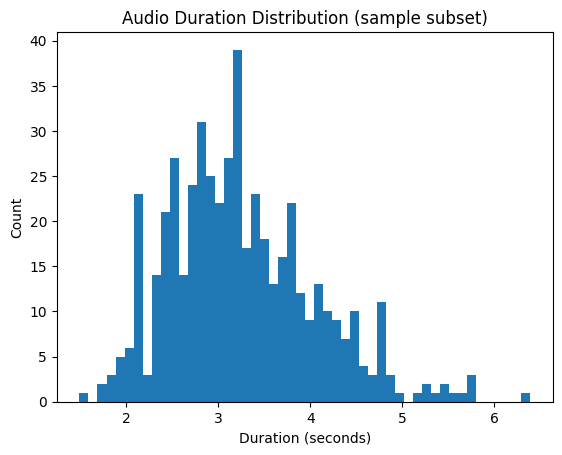

In [ ]:
# Plot Duration Distribution

plt.hist(durations, bins=50)
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Audio Duration Distribution (sample subset)")
plt.show()



**Duration Analysis Note**.  
The audio clips in the ASVspoof Logical Access split have relatively consistent durations, generally clustered between 2.5 and 4.5 seconds, with occasional samples extending slightly beyond 5 seconds. This narrow duration range reflects the dataset's controlled generation process and indicates that duration is not a discriminative feature between spoofed and bona-fide speech.
From a modeling perspective, this consistency makes it feasible to use fixed-size spectrogram inputs without excessive padding or truncation.

## **4.3 Listening to Real vs Spoof Samples**
Listening to a few samples helps build intuition about what makes spoofed speech sound different from bona-fide speech.  
Unlike image tasks, a lot of deepfake artifacts in speech are perceptual (e.g., robotic prosody, vocoder noise, unnatural pauses), so auditory inspection is an important qualitative step in speech anti-spoofing work.

In [ ]:
import random
import IPython.display as ipd

# Find indices for real and spoof samples
real_indices = metadata[metadata['label']==0].index
spoof_indices = metadata[metadata['label']==1].index

# randomly pick one of each
real_idx = random.choice(real_indices.tolist())
spoof_idx = random.choice(spoof_indices.tolist())


In [ ]:
# print
print('Real sample:', metadata.iloc[spoof_idx]['filepath'])
y_real, sr_real = librosa.load(metadata.iloc[real_idx]['filepath'], sr=None)
ipd.display(ipd.Audio(y_real, rate=sr_real))


Real sample: /content/asvspoof/ASVspoof2019_LA_train/flac/LA_T_8497475.flac


In [ ]:
print('Spoof sample:', metadata.iloc[spoof_idx]['filepath'])
y_spoof, sr_spoof = librosa.load(metadata.iloc[spoof_idx]['filepath'], sr=None)
ipd.display(ipd.Audio(y_spoof, rate = sr_spoof))

Spoof sample: /content/asvspoof/ASVspoof2019_LA_train/flac/LA_T_8497475.flac


**Listening Note**

After listening to sample bona-fide and spoof clips, the spoof audio in ASVspoof LA is noticeably distinguishable from real speech. Spoofed samples exhibit robotic artifacts, flatter prosody, and unnatural transitions, making them easier for a human to identify.


In [ ]:
# Export audio file as WAV and download
import soundfile as sf

sf.write('/content/real_sample.wav', y_real, sr_real)
sf.write('/content/spof_sample.wav', y_spoof, sr_spoof)

# Download

from google.colab import files
files.download('/content/real_sample.wav')
files.download('/content/spof_sample.wav')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **4.4 Spectrogram Inspection (Real vs Spoof)**
Visualizing spectrograms helps reveal acoustic differences between bona-fide and spoofed speech. CNN-based models for audio typically operate on time-frequency representations (e.g., Mel spectrograms), so it is useful to inspect how these representations differ between classes before training.  

To visually compare the time-frequency structure of bona-fide (real) and spoofed speech samples, we compute Mel-spectrograms from their raw waveforms. A Mel-spectrogram represents energy across perceptually meaningful frequency bands over time.

`y_real` and `y_spoof` were created in the listening section.

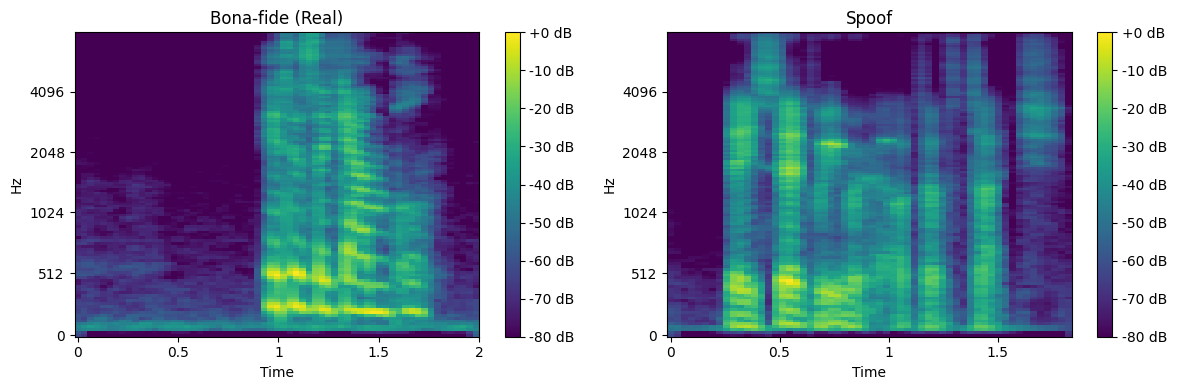

In [ ]:
# Import libraries

import numpy as np
import librosa
import librosa.display

# # compute mel spectrogram (128 mel bands is standard)

S_real = librosa.feature.melspectrogram(y=y_real, sr=sr_real, n_mels=128)
S_spoof = librosa.feature.melspectrogram(y=y_spoof, sr=sr_spoof, n_mels=128)

# convert to dB (log scale) for visualization
S_real_db = librosa.power_to_db(S_real, ref=np.max)
S_spoof_db = librosa.power_to_db(S_spoof, ref=np.max)

# Plot Melspcetrogram side by side

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
librosa.display.specshow(S_real_db, sr=sr_real, cmap='viridis', x_axis='time', y_axis='mel')
plt.title('Bona-fide (Real)')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1,2,2)
librosa.display.specshow(S_spoof_db, sr=sr_spoof, cmap='viridis', x_axis='time', y_axis='mel')
plt.title('Spoof')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()

**Observation:**

Real (Bona-fide) Speech:

- Shows more irregular harmonic structure
- Contains micro-variations, breathiness, and slight imperfections
- Energy distribution is often less uniform across higher frequency bands

Spoofed Speech:

- Displays more artificially stable harmonic patterns
- High-frequency content appears more consistent and textured
- Reflects characteristics from vocoders or neural TTS synthesizers

## **4.5 Spoof Attack Type Distribution**
ASVspoof LA contains multiple spoofing attack types (A01-A06) generated using different synthesis or voice conversion systems. Some attacks may occur more frequently than others, which can impact how well a model generalizes across spoofing techniques. A simple count plot helps visualize this distribution.

In [ ]:
metadata.attack.value_counts()

,count
attack,
A01,7516
A02,7516
A03,7516
A04,7516
A05,7516
A06,7516


/tmp/ipython-input-920818219.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spoof_only['attack'] = spoof_only['attack'].astype(str)


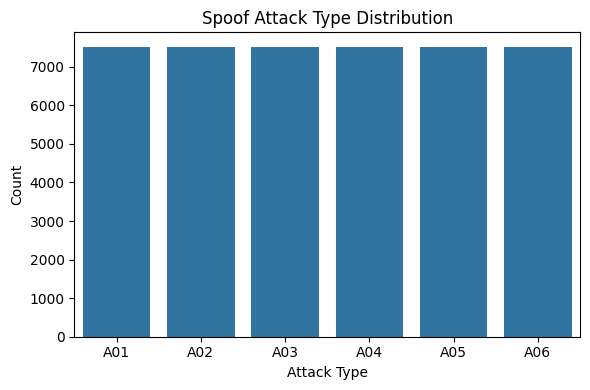

In [ ]:
import seaborn as sns

# FIlter only spoof samples
spoof_only = metadata[metadata['label']==1]
spoof_only['attack'] = spoof_only['attack'].astype(str)

# plot
plt.figure(figsize=(6,4))
sns.countplot(data=spoof_only, x='attack')
plt.title("Spoof Attack Type Distribution")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

**Observation**

ASVspoof 2019 LA includes six spoofing systems (A01–A06) corresponding to different speech synthesis or voice conversion pipelines. Visualizing the distribution of spoof attack types confirms that the dataset is evenly balanced across all six systems. This ensures that no particular spoofing strategy dominates the training data, which helps prevent the model from overfitting to a specific synthesis method and improves generalization across spoof types.

## **Summary**
In this notebook, we prepared and explored the ASVspoof 2019 LA dataset for spoofed speech detection. We parsed protocol files to build a unified metadata table containing file paths, labels, dataset splits, durations, and spoof attack identifiers (A01-A06). Exploratory checks showed that spoofed samples dominate the dataset, while attack types are evenly represented. Mel-spectrogram inspection revealed noticeable spectral differences between bona-fide and spoofed speech, supporting the use of time–frequency features for modeling. These findings justify the need for fixed-length preprocessing and log-mel feature extraction, which will be implemented in the next notebook along with model training.

In [ ]:
# Save metadata
metadata.to_csv('/content/drive/MyDrive/Deepfake vs Real/ASVspoof/asvspoof_metadata.csv', index=False)